In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!sudo rm -f /etc/boto.cfg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import saving_train
import loading_ds_train

import loading_ds_test
import saving_test

In [2]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [3]:
## Optional: remove sliced images from directory if necessary
!rm -r 'data/091'
!rm -r 'data/094'

In [4]:
training_image_path_list = ['tumor_094.tif', 'tumor_091.tif']

In [5]:
saving_train.train_part_1(training_image_path_list,num_pixels = 64, num_level = 3)

tumor_094.tif tumor_094_mask.tif
tumor_091.tif tumor_091_mask.tif


In [6]:
saving_train.save_second_level(training_image_path_list, input_level = 3, num_input_pixels = 64, 
                                                       output_level = 4, num_output_pixels = 64)

In [7]:
ds_train, steps_per_epoch_train = loading_ds_train.train_part_2(training_image_path_list,
                                                                num_level_1 = 3,
                                                                num_level_2 = 4)

In [8]:
## Imagenet bases using model subclassing
class dense_conv_split_model(tf.keras.Model):

    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='dense_conv_split_model')

        conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                                include_top=False)#,
                                                #input_shape=(128, 128, 3))
        conv_base.trainable = False

        self.cnn1 = conv_base
        self.model1_flatten1  = tf.keras.layers.Flatten()

        self.cnn2 = conv_base
        self.model2_flatten2 = tf.keras.layers.Flatten()

        self.merge_layer = tf.layers.Dense(32, activation='relu')
        self.final = tf.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2 = x[0], x[1]

        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)

        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)

        x = tf.concat([x1, x2], 1)
        x = self.merge_layer(x)
        x = self.final(x)

        return x

In [9]:
model = dense_conv_split_model()

In [10]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

In [11]:
ds_train

<PrefetchDataset shapes: (((?, 128, 128, 3), (?, 128, 128, 3)), (?,)), types: ((tf.float32, tf.float32), tf.int64)>

In [13]:
## Compile and train model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history = model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch_train)

Epoch 1/10
135/135 [==============================] - 27s 203ms/step - loss: 0.2256 - acc: 0.9111
Epoch 2/10
135/135 [==============================] - 23s 169ms/step - loss: 0.1922 - acc: 0.9167
Epoch 3/10
135/135 [==============================] - 23s 169ms/step - loss: 0.1457 - acc: 0.9463
Epoch 4/10
135/135 [==============================] - 23s 169ms/step - loss: 0.1219 - acc: 0.9556
Epoch 5/10
135/135 [==============================] - 23s 169ms/step - loss: 0.0678 - acc: 0.9796
Epoch 6/10
135/135 [==============================] - 23s 169ms/step - loss: 0.1426 - acc: 0.9352
Epoch 7/10
135/135 [==============================] - 23s 169ms/step - loss: 0.0239 - acc: 0.9963
Epoch 8/10
135/135 [==============================] - 23s 169ms/step - loss: 0.0774 - acc: 0.9667
Epoch 9/10
135/135 [==============================] - 23s 169ms/step - loss: 0.0361 - acc: 0.9870
Epoch 10/10
135/135 [==============================] - 23s 169ms/step - loss: 0.0343 - acc: 0.9852


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  524320    
_________________________________________________________________
dense_2 (Dense)              multiple                  66        
Total params: 15,239,074
Trainable params: 524,386
Non-trainable params: 14,714,688
_________________________________________________________________


{'loss': [0.22564939902343514, 0.1922290586008684, 0.1457291406056794, 0.12188534652723994, 0.0678058540481962, 0.14263341067536978, 0.023858008832416157, 0.07741087438783628, 0.0360749515880141, 0.034345712691780744], 'acc': [0.9111111111111111, 0.9166666666666666, 0.9462962962962963, 0.9555555555555556, 0.9796296296296296, 0.9351851851851852, 0.9962962962962963, 0.9666666666666667, 0.987037037037037, 0.9851851851851852]}


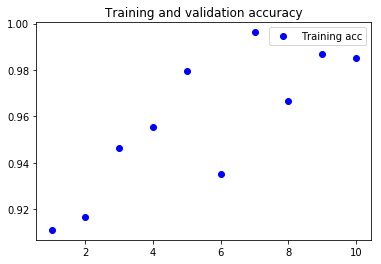

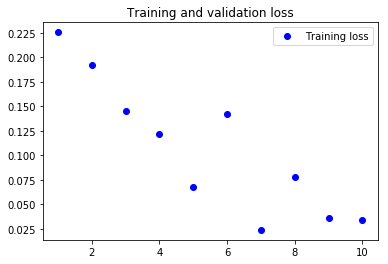

In [15]:
## Plot results
print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

## image 110

In [16]:
# image from test set
image_path = 'tumor_110.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

tumor_110.tif tumor_110_mask.tif


In [17]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

Precision: 0.945706262787245
Recall: 0.9046415612092273
F1: 0.9247182382881849
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     15669232       811344
Reality 1      1489684     14132258
           Predicted 0  Predicted 1
Reality 0    48.809978     2.527353
Reality 1     4.640396    44.022273


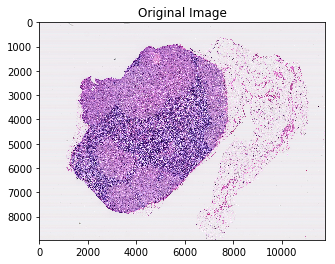

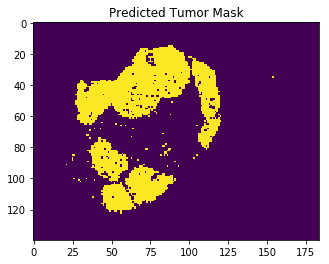

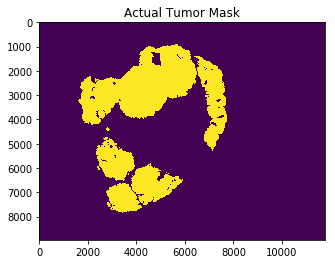

In [19]:
loading_ds_test.test_part_2(image_path,
            model,
            tissue_regions,
            slide_image_test,
            tumor_mask, image_depth,
            image_width,
            num_level_1 = 3,
            num_level_2 = 4)

## image 101

In [20]:
# image from test set
image_path = 'tumor_101.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

tumor_101.tif tumor_101_mask.tif


In [21]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

Precision: 0.5580605044412201
Recall: 0.8014712318249767
F1: 0.6579757250180102
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     29382653      1841854
Reality 1       576115      2325807
           Predicted 0  Predicted 1
Reality 0    86.099407     5.397148
Reality 1     1.688178     6.815266


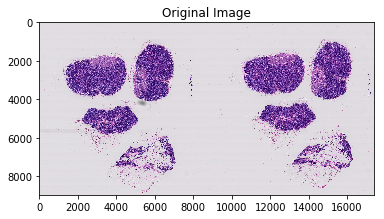

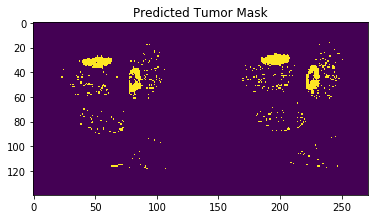

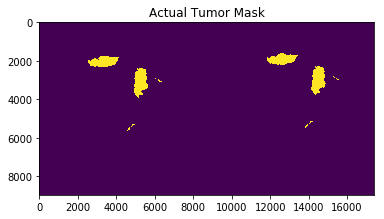

In [22]:
loading_ds_test.test_part_2(image_path,
            model,
            tissue_regions,
            slide_image_test,
            tumor_mask, image_depth,
            image_width,
            num_level_1 = 3,
            num_level_2 = 4)

# image 78

In [ ]:
# image from test set
image_path = 'tumor_078.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

tumor_078.tif tumor_078_mask.tif


In [ ]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

In [ ]:
loading_ds_test.test_part_2(image_path,
            model,
            tissue_regions,
            slide_image_test,
            tumor_mask, image_depth,
            image_width,
            num_level_1 = 3,
            num_level_2 = 4)

# image 81

In [ ]:
# image from test set
image_path = 'tumor_081.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

In [ ]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

In [ ]:
loading_ds_test.test_part_2(image_path,
            model,
            tissue_regions,
            slide_image_test,
            tumor_mask, image_depth,
            image_width,
            num_level_1 = 3,
            num_level_2 = 4)